# Polish Presidential Election Data Analysis

This notebook consists of both the data processing and modeling for my prediction of the second round results of the 2025 Polish presidential election. This project was inspired by and largely draws from [Cezary Klimczuk's analysis performed in 2020](https://towardsdatascience.com/president-duda-heading-for-a-firm-re-election-according-to-262-144-simulations-3f5f6ceddb04/), utilizing the same general methodology but applying it to the current 2025 election results. Polish presidential elections use a two-round system, where a run-off election is held between the top two candidates if no candidate receives an outright majority in round 1. Since its origin in 1990, only once has an election not gone to the second round (2000). It is generally assumed that elections will always reach this second stage. In a nutshell, a simple OLS regression is utilized to predict the increase in voter share captured between rounds for a candidate in a given powiat (county). By modelling these regressions for previous elections, we can predict general ranges for possible coefficients for the 2025 election, and simulate possible election outcomes. The model gives Rafał Trzaskowski of PO a 60.3% chance to beat Karol Nawrocki (an independent, but assumed to be aligned with the right-wing party, PiS). As of 9:30 AM, May 26th, [PolyMarket traders](https://polymarket.com/event/poland-presidential-election?tid=1748251262584) give Trzaskowski a 60% chance of winning the election, betfan.pl gives Trzaskowski a 46.67% chance, and efortuna.pl gives him a 46.03% chance. The notebook begins with the [processing and cleaning](#Data-Cleaning-and-Processing) of the election result data, before being concluded with the [data visualization, modeling, and simulation](#data-visualization-modeling-and-simulation) section. [Data](https://danewyborcze.kbw.gov.pl/indexc4fa.html?title=Strona_g%C5%82%C3%B3wna) is sourced from the public center of polish election results, and can additionally be found in the attached data folder.

## Data Cleaning and Processing

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm
from tqdm import tqdm
from itertools import product


In [2]:
#Load excel sheets
round_1_2005 = pd.read_excel("polish_election_data/2005_round_1.xls")
round_2_2005 = pd.read_excel("polish_election_data/2005_round_2.xls")
round_1_2010 = pd.read_excel("polish_election_data/2010_round_1.xls")
round_2_2010 = pd.read_excel("polish_election_data/2010_round_2.xls")
round_1_2015 = pd.read_excel("polish_election_data/2015_round_1.xls")
round_2_2015 = pd.read_excel("polish_election_data/2015_round_2.xls")
round_1_2020 = pd.read_excel("polish_election_data/2020_round_1.xlsx")
round_2_2020 = pd.read_excel("polish_election_data/2020_round_2.xlsx")
round_1_2025 = pd.read_excel("polish_election_data/2025_round_1.xlsx")


The analysis is performed on the county level, therefore we require a unique identifier for counties. We immediately see that the datasets differ in their length as well as the titles for their respective identifiers.


In [3]:
dfs = [round_1_2005, round_2_2005, round_1_2010, round_2_2010, round_1_2015, round_2_2015, round_1_2020, round_2_2020, round_1_2025]
df_names = [
    "round_1_2005", "round_2_2005", "round_1_2010", "round_2_2010",
    "round_1_2015", "round_2_2015", "round_1_2020", "round_2_2020", "round_1_2025"
]

for i in range(len(dfs)):
    if 'Powiat' in dfs[i].columns:
        dfs[i] = dfs[i].dropna(subset=['Powiat'])

for name, df in zip(df_names, dfs):
    teryt_cols = [col for col in df.columns if "teryt" in col.lower()]
    print(f"{name}: {teryt_cols}")
    print(f"{name}: {len(df)}")

round_1_2005: ['TERYT']
round_1_2005: 382
round_2_2005: ['TERYT']
round_2_2005: 382
round_1_2010: ['TERYT']
round_1_2010: 381
round_2_2010: ['TERYT']
round_2_2010: 381
round_1_2015: ['TERYT']
round_1_2015: 382
round_2_2015: ['TERYT']
round_2_2015: 382
round_1_2020: ['Kod TERYT']
round_1_2020: 382
round_2_2020: ['Kod TERYT']
round_2_2020: 382
round_1_2025: ['TERYT Powiatu']
round_1_2025: 382


We rename the identifier columns to "County_Code" for all data frames.

In [4]:
for i, df in enumerate(dfs):
    rename_dict = {col: "County_Code" for col in df.columns if "teryt" in col.lower()}
    dfs[i] = df.rename(columns=rename_dict)

for name, df in zip(df_names, dfs):
    globals()[name] = df


Upon inspecting the county codes, we are immediately met with the fact that 2015 seems to trim the trailing zeros. However, for certain county codes with more than 3 non-zero charachters, 2015 utilizes a slight variation in county code. County code cannot be simply adopted across all data frames and must be further processed in the future. Additionally, due to slight deviations in the ordering of the initial data sets, we cannot simply map code values from one data frame upon another without requiring further edits.

In [5]:
for name, df in zip(df_names, dfs):
    print(f"{name}: {df['County_Code'].iloc[0]}, {df['County_Code'].iloc[1]} ")

round_1_2005: 20100, 20200 
round_2_2005: 20100.0, 20200.0 
round_1_2010: 20100, 20200 
round_2_2010: 20100, 20200 
round_1_2015: 201, 202 
round_2_2015: 201, 202 
round_1_2020: 20100, 20200 
round_2_2020: 20100, 20200 
round_1_2025: 20100.0, 20200.0 


We first transform the identifier to a string for easier further use.

In [6]:
round_1_2005["County_Code"] = round_1_2005["County_Code"].astype(int).astype(str)
round_2_2005["County_Code"] = round_2_2005["County_Code"].astype(int).astype(str)
round_1_2010["County_Code"] = round_1_2010["County_Code"].astype(int).astype(str)
round_2_2010["County_Code"] = round_2_2010["County_Code"].astype(int).astype(str)
round_1_2015["County_Code"] = round_1_2015["County_Code"].astype(int).astype(str)
round_2_2015["County_Code"] = round_2_2015["County_Code"].astype(int).astype(str)
round_1_2020["County_Code"] = round_1_2020["County_Code"].astype(int).astype(str)
round_2_2020["County_Code"] = round_2_2020["County_Code"].astype(int).astype(str)
round_1_2025.loc[round_1_2025["County_Code"].notna(), "County_Code"] = round_1_2025.loc[round_1_2025["County_Code"].notna(), "County_Code"].astype(int).astype(str)

/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_35826/2331278375.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['20100' '20200' '20300' '20400' '20500' '20600' '20700' '20800' '20900'
 '21000' '21100' '21200' '21300' '21400' '21500' '21600' '21700' '21800'
 '21900' '22000' '22100' '22200' '22300' '22400' '22500' '22600' '26100'
 '26200' '26400' '26500' '40100' '40200' '40300' '40400' '40500' '40600'
 '40700' '40800' '40900' '41000' '41100' '41200' '41300' '41400' '41500'
 '41600' '41700' '41800' '41900' '46100' '46200' '46300' '46400' '60100'
 '60200' '60300' '60400' '60500' '60600' '60700' '60800' '60900' '61000'
 '61100' '61200' '61300' '61400' '61500' '61600' '61700' '61800' '61900'
 '62000' '66100' '66200' '66300' '66400' '80100' '80200' '80300' '80400'
 '80500' '80600' '80700' '80800' '80900' '81000' '81100' '81200' '86100'
 '86200' '100100' '100200' '100300' '100400' '100500' '1006

In [7]:
for name, df in zip(df_names, dfs):
    print(f"{name}: {df['County_Code'].iloc[0]}, {df['County_Code'].iloc[1]} ")

round_1_2005: 20100, 20200 
round_2_2005: 20100, 20200 
round_1_2010: 20100, 20200 
round_2_2010: 20100, 20200 
round_1_2015: 201, 202 
round_2_2015: 201, 202 
round_1_2020: 20100, 20200 
round_2_2020: 20100, 20200 
round_1_2025: 20100, 20200 


Knowing that county codes change slightly over the years, we must first set a list of counties for the analysis by name, before remapping their codes. I began by investigating specific string differences year over year.

In [8]:
print(round_1_2005[round_1_2005["County_Code"] == "66201"]["Powiat"].iloc[0])
print(round_2_2005[round_2_2005["County_Code"] == "66201"]["Powiat"].iloc[0])
print(round_1_2010[round_1_2010["County_Code"] == "66201"]["Powiat"].iloc[0])
print(round_2_2010[round_2_2010["County_Code"] == "66201"]["Powiat"].iloc[0])
print(round_1_2015[round_1_2015["County_Code"] == "662"]["Powiat"].iloc[0])
print(round_2_2015[round_2_2015["County_Code"] == "662"]["Powiat"].iloc[0])
print(round_1_2020[round_1_2020["County_Code"] == "66200"]["Powiat"].iloc[0])
print(round_2_2020[round_2_2020["County_Code"] == "66200"]["Powiat"].iloc[0])
print(round_1_2025[round_1_2025["County_Code"] == "66200"]["Powiat"].iloc[0])

m. Chełm
m. Chełm
Chełm
Chełm
Chełm
Chełm
Chełm
Chełm
Chełm


Prevous data put an "m. " prefix in front of specific names. This is removed.

In [9]:
round_1_2005["Powiat"] = round_1_2005["Powiat"].str.replace(r"^m\. ", "", regex=True)
round_2_2005["Powiat"] = round_2_2005["Powiat"].str.replace(r"^m\. ", "", regex=True)

After this removal I utilized a matrix approach to identify differing county names over the years. Matrix entries include a list of asymettric items, being items that appear in one of the data frames but not the other.

In [10]:
county_sets = [set(df["Powiat"]) for df in dfs]

matrix = pd.DataFrame(index=df_names, columns=df_names)

for i in range(len(county_sets)):
    for j in range(len(county_sets)):
        non_overlap = county_sets[i].symmetric_difference(county_sets[j])
        matrix.iloc[i, j] = non_overlap

matrix

,round_1_2005,round_2_2005,round_1_2010,round_2_2010,round_1_2015,round_2_2015,round_1_2020,round_2_2020,round_1_2025
round_1_2005,{},"{Suski, suski}","{Statki, Warszawa, st. Warszawa, miechowski, S...","{Statki, Warszawa, st. Warszawa, miechowski, S...","{Statki, Warszawa, st. Warszawa, Suski, suski,...","{Statki, Warszawa, st. Warszawa, Suski, suski,...","{Statki, zagranica, Warszawa, st. Warszawa, Su...","{Statki, zagranica, Warszawa, st. Warszawa, Su...","{Statki, zagranica, Warszawa, st. Warszawa, Su..."
round_2_2005,"{Suski, suski}",{},"{Statki, Warszawa, st. Warszawa, Suski, miecho...","{Statki, Warszawa, st. Warszawa, Suski, miecho...","{Statki, Warszawa, st. Warszawa, Wałbrzych, st...","{Statki, Warszawa, st. Warszawa, Wałbrzych, st...","{Statki, zagranica, Warszawa, st. Warszawa, Wa...","{Statki, zagranica, Warszawa, st. Warszawa, Wa...","{Statki, zagranica, Warszawa, st. Warszawa, Wa..."
round_1_2010,"{Statki, Warszawa, st. Warszawa, miechowski, S...","{Statki, Warszawa, st. Warszawa, Suski, miecho...",{},{},"{Suski, miechowski, Statki - Gdańsk, suski, Wa...","{Suski, miechowski, Statki - Gdańsk, suski, Wa...","{zagranica, Suski, miechowski, Statki - Gdańsk...","{zagranica, Suski, miechowski, Statki - Gdańsk...","{zagranica, Suski, miechowski, Statki - Gdańsk..."
round_2_2010,"{Statki, Warszawa, st. Warszawa, miechowski, S...","{Statki, Warszawa, st. Warszawa, Suski, miecho...",{},{},"{Suski, miechowski, Statki - Gdańsk, suski, Wa...","{Suski, miechowski, Statki - Gdańsk, suski, Wa...","{zagranica, Suski, miechowski, Statki - Gdańsk...","{zagranica, Suski, miechowski, Statki - Gdańsk...","{zagranica, Suski, miechowski, Statki - Gdańsk..."
round_1_2015,"{Statki, Warszawa, st. Warszawa, Suski, suski,...","{Statki, Warszawa, st. Warszawa, Wałbrzych, st...","{Suski, miechowski, Statki - Gdańsk, suski, Wa...","{Suski, miechowski, Statki - Gdańsk, suski, Wa...",{},{},"{zagranica, Zagranica}","{zagranica, Zagranica}","{zagranica, karkonoski, Zagranica, jeleniogórski}"
round_2_2015,"{Statki, Warszawa, st. Warszawa, Suski, suski,...","{Statki, Warszawa, st. Warszawa, Wałbrzych, st...","{Suski, miechowski, Statki - Gdańsk, suski, Wa...","{Suski, miechowski, Statki - Gdańsk, suski, Wa...",{},{},"{zagranica, Zagranica}","{zagranica, Zagranica}","{zagranica, karkonoski, Zagranica, jeleniogórski}"
round_1_2020,"{Statki, zagranica, Warszawa, st. Warszawa, Su...","{Statki, zagranica, Warszawa, st. Warszawa, Wa...","{zagranica, Suski, miechowski, Statki - Gdańsk...","{zagranica, Suski, miechowski, Statki - Gdańsk...","{zagranica, Zagranica}","{zagranica, Zagranica}",{},{},"{karkonoski, jeleniogórski}"
round_2_2020,"{Statki, zagranica, Warszawa, st. Warszawa, Su...","{Statki, zagranica, Warszawa, st. Warszawa, Wa...","{zagranica, Suski, miechowski, Statki - Gdańsk...","{zagranica, Suski, miechowski, Statki - Gdańsk...","{zagranica, Zagranica}","{zagranica, Zagranica}",{},{},"{karkonoski, jeleniogórski}"
round_1_2025,"{Statki, zagranica, Warszawa, st. Warszawa, Su...","{Statki, zagranica, Warszawa, st. Warszawa, Wa...","{zagranica, Suski, miechowski, Statki - Gdańsk...","{zagranica, Suski, miechowski, Statki - Gdańsk...","{zagranica, karkonoski, Zagranica, jeleniogórski}","{zagranica, karkonoski, Zagranica, jeleniogórski}","{karkonoski, jeleniogórski}","{karkonoski, jeleniogórski}",{}


First, I put all characters in lowercase and remove trailing spaces. After this transformation all data sets within the same year are identical in their naming and in the interest of visual brevity only one data set per year needs to be included in subsequent matrices.

In [11]:
round_1_2005["Powiat"] = round_1_2005["Powiat"].str.lower().str.strip()
round_2_2005["Powiat"] = round_2_2005["Powiat"].str.lower().str.strip()
round_1_2010["Powiat"] = round_1_2010["Powiat"].str.lower().str.strip()
round_2_2010["Powiat"] = round_2_2010["Powiat"].str.lower().str.strip()
round_1_2015["Powiat"] = round_1_2015["Powiat"].str.lower().str.strip()
round_2_2015["Powiat"] = round_2_2015["Powiat"].str.lower().str.strip()
round_1_2020["Powiat"] = round_1_2020["Powiat"].str.lower().str.strip()
round_2_2020["Powiat"] = round_2_2020["Powiat"].str.lower().str.strip()
round_1_2025["Powiat"] = round_1_2025["Powiat"].str.lower().str.strip()

In [12]:
county_sets = [set(df["Powiat"]) for df in [round_1_2005, round_1_2010, round_1_2015, round_1_2020, round_1_2025]]

matrix = pd.DataFrame(index=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"], columns=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"])

for i in range(len(county_sets)):
    for j in range(len(county_sets)):
        non_overlap = county_sets[i].symmetric_difference(county_sets[j])
        matrix.iloc[i, j] = non_overlap

matrix

,round_1_2005,round_1_2010,round_1_2015,round_1_2020,round_1_2025
round_1_2005,{},"{st. warszawa, statki - gdańsk, statki, warszawa}","{st. warszawa, wałbrzych, warszawa}","{st. warszawa, wałbrzych, warszawa}","{st. warszawa, wałbrzych, warszawa, karkonoski..."
round_1_2010,"{st. warszawa, statki - gdańsk, statki, warszawa}",{},"{statki - gdańsk, statki, wałbrzych}","{statki - gdańsk, statki, wałbrzych}","{statki - gdańsk, statki, wałbrzych, karkonosk..."
round_1_2015,"{st. warszawa, wałbrzych, warszawa}","{statki - gdańsk, statki, wałbrzych}",{},{},"{karkonoski, jeleniogórski}"
round_1_2020,"{st. warszawa, wałbrzych, warszawa}","{statki - gdańsk, statki, wałbrzych}",{},{},"{karkonoski, jeleniogórski}"
round_1_2025,"{st. warszawa, wałbrzych, warszawa, karkonoski...","{statki - gdańsk, statki, wałbrzych, karkonosk...","{karkonoski, jeleniogórski}","{karkonoski, jeleniogórski}",{}


I identify that the statki column frequently repeats itself. Statki translates to ships in English, and in this context it literally refers to people voting from ships (typically millitary ships or offshore oil rigs). They represent an incredibly small number of people and will be removed from all data sets.

In [13]:
round_2_2005.sort_values("Uprawnieni\ndo głosowania").head()

,County_Code,Powiat,Uprawnieni\ndo głosowania,Wydane karty\ndo głosowania,Unnamed: 4,Karty wyjęte\n(głosy oddane),Głosy\nnieważne,Unnamed: 7,Głosy\nważne,Unnamed: 9,Lech Aleksander\nKaczyński,Unnamed: 11,Donald Franciszek\nTusk,Unnamed: 13
382,329901,statki,48.0,48,100,48.0,3,6.25,45,93.75,21,46.666667,24,53.333333
254,229901,statki,114.0,114,100,114.0,5,4.385965,109,95.614035,32,29.357798,77,70.642202
225,200900,sejneński,17185.0,6104,35.519348,6103.0,66,1.081435,6037,98.918565,3697,61.239026,2340,38.760974
192,180100,bieszczadzki,17542.0,7498,42.743131,7498.0,64,0.853561,7434,99.146439,4461,60.008071,2973,39.991929
323,281900,węgorzewski,19444.0,7303,37.559144,7299.0,110,1.507056,7189,98.492944,3064,42.62067,4125,57.37933


In [14]:
round_1_2005 = round_1_2005[~round_1_2005["Powiat"].str.contains("statki")]
round_2_2005 = round_2_2005[~round_2_2005["Powiat"].str.contains("statki")]
round_1_2010 = round_1_2010[~round_1_2010["Powiat"].str.contains("statki")]
round_2_2010 = round_2_2010[~round_2_2010["Powiat"].str.contains("statki")]
round_1_2015 = round_1_2015[~round_1_2015["Powiat"].str.contains("statki")]
round_2_2015 = round_2_2015[~round_2_2015["Powiat"].str.contains("statki")]
round_1_2020 = round_1_2020[~round_1_2020["Powiat"].str.contains("statki")]
round_2_2020 = round_2_2020[~round_2_2020["Powiat"].str.contains("statki")]
round_1_2025 = round_1_2025[~round_1_2025["Powiat"].str.contains("statki")]


In [15]:
matrix = pd.DataFrame(index=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"], columns=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"])

for i in range(len(county_sets)):
    for j in range(len(county_sets)):
        non_overlap = county_sets[i].symmetric_difference(county_sets[j])
        matrix.iloc[i, j] = non_overlap

matrix

,round_1_2005,round_1_2010,round_1_2015,round_1_2020,round_1_2025
round_1_2005,{},"{st. warszawa, statki - gdańsk, statki, warszawa}","{st. warszawa, wałbrzych, warszawa}","{st. warszawa, wałbrzych, warszawa}","{st. warszawa, wałbrzych, warszawa, karkonoski..."
round_1_2010,"{st. warszawa, statki - gdańsk, statki, warszawa}",{},"{statki - gdańsk, statki, wałbrzych}","{statki - gdańsk, statki, wałbrzych}","{statki - gdańsk, statki, wałbrzych, karkonosk..."
round_1_2015,"{st. warszawa, wałbrzych, warszawa}","{statki - gdańsk, statki, wałbrzych}",{},{},"{karkonoski, jeleniogórski}"
round_1_2020,"{st. warszawa, wałbrzych, warszawa}","{statki - gdańsk, statki, wałbrzych}",{},{},"{karkonoski, jeleniogórski}"
round_1_2025,"{st. warszawa, wałbrzych, warszawa, karkonoski...","{statki - gdańsk, statki, wałbrzych, karkonosk...","{karkonoski, jeleniogórski}","{karkonoski, jeleniogórski}",{}


I change st. warszawa to warszawa by trimming the "st. " prefix off the front.

In [16]:
round_1_2005[round_1_2005["Powiat"] == "st. warszawa"]

,OKW,County_Code,Powiat,Liczba obwodów,Uprawnieni do głosowania,Otrzymane karty\ndo głosowania,Karty niewykorzystane,Karty wydane (frekwencja),Głosy oddane,Głosy ważne,...,Bubel Leszek Henryk,Ilasz Liwiusz Marian,Kaczyński Lech Aleksander,Kalinowski Jarosław,Korwin-Mikke Janusz Ryszard,Lepper Andrzej Zbigniew,Pyszko Jan,Słomka Adam Andrzej,Tusk Donald Franciszek,Tymiński Stanisław
177,23,146501,st. warszawa,819,1352256,1280263,420934,859394,858693,854270,...,1175,983,275968,5494,17219,24224,369,299,412903,709


In [17]:
round_1_2025[round_1_2025["County_Code"] == "146501"]

,County_Code,Powiat,Województwo,Liczba komisji,Liczba uwzględnionych komisji,Komisja otrzymała kart do głosowania,Liczba wyborców uprawnionych do głosowania,Nie wykorzystano kart do głosowania,"Liczba wyborców, którym wydano karty do głosowania w lokalu wyborczym","Liczba wyborców, którym wysłano pakiety wyborcze",...,HOŁOWNIA Szymon Franciszek,JAKUBIAK Marek,MACIAK Maciej,MENTZEN Sławomir Jerzy,NAWROCKI Karol Tadeusz,SENYSZYN Joanna,STANOWSKI Krzysztof Jakub,TRZASKOWSKI Rafał Kazimierz,WOCH Marek Marian,ZANDBERG Adrian Tadeusz
178,146501,warszawa,mazowieckie,851,851,1298904,1379227,205281,1093416,847,...,58602,9781,1472,103910,199119,19616,17880,460616,1016,92369


In [18]:
round_1_2005["Powiat"] = round_1_2005["Powiat"].str.replace(r"^st\. ", "", regex=True)
round_2_2005["Powiat"] = round_2_2005["Powiat"].str.replace(r"^st\. ", "", regex=True)

/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_35826/3242697033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_1_2005["Powiat"] = round_1_2005["Powiat"].str.replace(r"^st\. ", "", regex=True)
/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_35826/3242697033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_2_2005["Powiat"] = round_2_2005["Powiat"].str.replace(r"^st\. ", "", regex=True)


We are left with Wałbrzych, Jeleniogórski, and Karkonoski. I could not find results for Wałbrzych before 2015, so for consistency I will remove it entirely.

In [19]:
county_sets = [set(df["Powiat"]) for df in [round_1_2005, round_1_2010, round_1_2015, round_1_2020, round_1_2025]]

matrix = pd.DataFrame(index=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"], columns=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"])

for i in range(len(county_sets)):
    for j in range(len(county_sets)):
        non_overlap = county_sets[i].symmetric_difference(county_sets[j])
        matrix.iloc[i, j] = non_overlap

matrix

,round_1_2005,round_1_2010,round_1_2015,round_1_2020,round_1_2025
round_1_2005,{},{},{wałbrzych},{wałbrzych},"{wałbrzych, karkonoski, jeleniogórski}"
round_1_2010,{},{},{wałbrzych},{wałbrzych},"{wałbrzych, karkonoski, jeleniogórski}"
round_1_2015,{wałbrzych},{wałbrzych},{},{},"{karkonoski, jeleniogórski}"
round_1_2020,{wałbrzych},{wałbrzych},{},{},"{karkonoski, jeleniogórski}"
round_1_2025,"{wałbrzych, karkonoski, jeleniogórski}","{wałbrzych, karkonoski, jeleniogórski}","{karkonoski, jeleniogórski}","{karkonoski, jeleniogórski}",{}


In [20]:
round_1_2015 = round_1_2015[~round_1_2015["Powiat"].str.contains("wałbrzych")]
round_2_2015 = round_2_2015[~round_2_2015["Powiat"].str.contains("wałbrzych")]
round_1_2020 = round_1_2020[~round_1_2020["Powiat"].str.contains("wałbrzych")]
round_2_2020 = round_2_2020[~round_2_2020["Powiat"].str.contains("wałbrzych")]
round_1_2025 = round_1_2025[~round_1_2025["Powiat"].str.contains("wałbrzych")]


After a quick inspection, it seems as if Jeleniogórski became Karkonoski for 2025. I will rename Karkonoski to Jeleniogórski.

In [21]:
county_sets = [set(df["Powiat"]) for df in [round_1_2005, round_1_2010, round_1_2015, round_1_2020, round_1_2025]]

matrix = pd.DataFrame(index=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"], columns=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"])

for i in range(len(county_sets)):
    for j in range(len(county_sets)):
        non_overlap = county_sets[i].symmetric_difference(county_sets[j])
        matrix.iloc[i, j] = non_overlap

matrix

,round_1_2005,round_1_2010,round_1_2015,round_1_2020,round_1_2025
round_1_2005,{},{},{},{},"{karkonoski, jeleniogórski}"
round_1_2010,{},{},{},{},"{karkonoski, jeleniogórski}"
round_1_2015,{},{},{},{},"{karkonoski, jeleniogórski}"
round_1_2020,{},{},{},{},"{karkonoski, jeleniogórski}"
round_1_2025,"{karkonoski, jeleniogórski}","{karkonoski, jeleniogórski}","{karkonoski, jeleniogórski}","{karkonoski, jeleniogórski}",{}


In [22]:
round_1_2025[round_1_2025["Powiat"] == "karkonoski"]

,County_Code,Powiat,Województwo,Liczba komisji,Liczba uwzględnionych komisji,Komisja otrzymała kart do głosowania,Liczba wyborców uprawnionych do głosowania,Nie wykorzystano kart do głosowania,"Liczba wyborców, którym wydano karty do głosowania w lokalu wyborczym","Liczba wyborców, którym wysłano pakiety wyborcze",...,HOŁOWNIA Szymon Franciszek,JAKUBIAK Marek,MACIAK Maciej,MENTZEN Sławomir Jerzy,NAWROCKI Karol Tadeusz,SENYSZYN Joanna,STANOWSKI Krzysztof Jakub,TRZASKOWSKI Rafał Kazimierz,WOCH Marek Marian,ZANDBERG Adrian Tadeusz
5,20600,karkonoski,dolnośląskie,60,60,49356,48363,19190,30166,9,...,1330,212,56,3579,6598,308,336,13235,25,1160


In [23]:
round_1_2015[round_1_2015["County_Code"] == "206"]

,County_Code,Powiat,Województwo,L. obw.,Liczba wyborców uprawnionych do głosowania,Komisja otrzymała kart do głosowania,Nie wykorzystano kart do głosowania,"Liczba wyborców, którym wydano karty do głosowania",Liczba wyborców głosujących przez pełnomocnika,Liczba wyborców głosujących na podstawie zaświadczenia,...,Duda Andrzej Sebastian,Jarubas Adam Sebastian,Komorowski Bronisław Maria,Korwin-Mikke Janusz Ryszard,Kowalski Marian Janusz,Kukiz Paweł Piotr,Ogórek Magdalena Agnieszka,Palikot Janusz Marian,Tanajno Paweł Jan,Wilk Jacek
5,206,jeleniogórski,dolnośląskie,56,52408,45025,22103,22922,13,475,...,5467,217,10333,635,85,4724,568,446,45,111


In [24]:
round_1_2025.loc[round_1_2025["Powiat"] == "karkonoski", "Powiat"] = "jeleniogórski"

We now have the same set of counties across all datasets.

In [25]:
county_sets = [set(df["Powiat"]) for df in [round_1_2005, round_1_2010, round_1_2015, round_1_2020, round_1_2025]]

matrix = pd.DataFrame(index=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"], columns=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"])

for i in range(len(county_sets)):
    for j in range(len(county_sets)):
        non_overlap = county_sets[i].symmetric_difference(county_sets[j])
        matrix.iloc[i, j] = non_overlap

matrix

,round_1_2005,round_1_2010,round_1_2015,round_1_2020,round_1_2025
round_1_2005,{},{},{},{},{}
round_1_2010,{},{},{},{},{}
round_1_2015,{},{},{},{},{}
round_1_2020,{},{},{},{},{}
round_1_2025,{},{},{},{},{}


We have 380 counties but only 370 codes. Additionally, we have a missing row in 2025 which after further analysis represent international votes. This issue will be rectified later.

In [26]:
print(len(round_1_2005), len(round_2_2005), len(round_1_2010), len(round_2_2010), len(round_1_2015), len(round_2_2015), len(round_1_2020), len(round_2_2020), len(round_1_2025))




print(round_1_2005["Powiat"].nunique(), round_2_2005["Powiat"].nunique(), round_1_2010["Powiat"].nunique(), round_2_2010["Powiat"].nunique(), 
      round_1_2015["Powiat"].nunique(), round_2_2015["Powiat"].nunique(), round_1_2020["Powiat"].nunique(), round_2_2020["Powiat"].nunique(), round_1_2025["Powiat"].nunique())

print(round_1_2005["County_Code"].nunique(), round_2_2005["County_Code"].nunique(), round_1_2010["County_Code"].nunique(), round_2_2010["County_Code"].nunique(), 
      round_1_2015["County_Code"].nunique(), round_2_2015["County_Code"].nunique(), round_1_2020["County_Code"].nunique(), round_2_2020["County_Code"].nunique(), round_1_2025["County_Code"].nunique())


380 380 380 380 380 380 380 380 380
370 370 370 370 370 370 370 370 370
380 380 380 380 380 380 380 380 379


In [27]:
round_1_2025[round_1_2025["County_Code"].isna()]

,County_Code,Powiat,Województwo,Liczba komisji,Liczba uwzględnionych komisji,Komisja otrzymała kart do głosowania,Liczba wyborców uprawnionych do głosowania,Nie wykorzystano kart do głosowania,"Liczba wyborców, którym wydano karty do głosowania w lokalu wyborczym","Liczba wyborców, którym wysłano pakiety wyborcze",...,HOŁOWNIA Szymon Franciszek,JAKUBIAK Marek,MACIAK Maciej,MENTZEN Sławomir Jerzy,NAWROCKI Karol Tadeusz,SENYSZYN Joanna,STANOWSKI Krzysztof Jakub,TRZASKOWSKI Rafał Kazimierz,WOCH Marek Marian,ZANDBERG Adrian Tadeusz
180,NaN,zagranica,NaN,511,511,697214,524204,229394,467802,0,...,15955,2931,917,77193,74829,5798,4182,171471,233,30140


It seems as if we have multiple counties with the same name.

In [28]:
round_1_2015.groupby("Powiat").agg(Count=("Powiat", "count")).query("Count > 1")

,Count
Powiat,
bielski,2
brzeski,2
grodziski,2
krośnieński,2
nowodworski,2
opolski,2
ostrowski,2
tomaszowski,2
średzki,2


These county duplicates are consistent across the data sets and all have counts of 2.

In [29]:
rounds = {
    "round_1_2005": round_1_2005,
    "round_2_2005": round_2_2005,
    "round_1_2010": round_1_2010,
    "round_2_2010": round_2_2010,
    "round_1_2015": round_1_2015,
    "round_2_2015": round_2_2015,
    "round_1_2020": round_1_2020,
    "round_2_2020": round_2_2020,
    "round_1_2025": round_1_2025
}

dupes_dict = {}

for name, df in rounds.items():
    dupes = df.groupby("Powiat").size()
    dupes = dupes[dupes > 1]  
    dupes_dict[name] = dupes

dupes_wide = pd.DataFrame(dupes_dict).fillna(0).astype(int)

dupes_wide = dupes_wide.loc[dupes_wide.sum(axis=1) > 0]

dupes_wide

,round_1_2005,round_2_2005,round_1_2010,round_2_2010,round_1_2015,round_2_2015,round_1_2020,round_2_2020,round_1_2025
Powiat,,,,,,,,,
bielski,2,2,2,2,2,2,2,2,2
brzeski,2,2,2,2,2,2,2,2,2
grodziski,2,2,2,2,2,2,2,2,2
krośnieński,2,2,2,2,2,2,2,2,2
nowodworski,2,2,2,2,2,2,2,2,2
opolski,2,2,2,2,2,2,2,2,2
ostrowski,2,2,2,2,2,2,2,2,2
tomaszowski,2,2,2,2,2,2,2,2,2
średzki,2,2,2,2,2,2,2,2,2


These counties are distinct from eachother and have distinct codes. They simply share the same name within the data.

In [30]:
round_1_dfs = {
    "round_1_2005": round_1_2005,
    "round_1_2010": round_1_2010,
    "round_1_2015": round_1_2015,
    "round_1_2020": round_1_2020,
    "round_1_2025": round_1_2025,
}



duplicate_powiats = dupes_wide.index.to_list()

results = []

for powiat in duplicate_powiats:
    powiat_result = {"Powiat": powiat}
    for name, df in round_1_dfs.items():
        codes = df[df["Powiat"] == powiat]["County_Code"].unique()
        powiat_result[name] = ", ".join(sorted(codes)) if len(codes) > 0 else ""
    results.append(powiat_result)

county_code_check_df = pd.DataFrame(results)

def is_duplicate(row):
    codes = [row[col] for col in round_1_dfs.keys() if row[col]]
    return len(set(codes)) == 1

county_code_check_df["Duplicate"] = county_code_check_df.apply(is_duplicate, axis=1)

county_code_check_df


,Powiat,round_1_2005,round_1_2010,round_1_2015,round_1_2020,round_1_2025,Duplicate
0,bielski,"200300, 240200","200300, 240200","2003, 2402","200300, 240200","200300, 240200",False
1,brzeski,"120200, 160100","120200, 160100","1202, 1601","120200, 160100","120200, 160100",False
2,grodziski,"140500, 300500","140500, 300500","1405, 3005","140500, 300500","140500, 300500",False
3,krośnieński,"180700, 80200","180700, 80200","1807, 802","180700, 80200","180700, 80200",False
4,nowodworski,"141400, 221000","141400, 221000","1414, 2210","141400, 221000","141400, 221000",False
5,opolski,"160900, 61200","160900, 61200","1609, 612","160900, 61200","160900, 61200",False
6,ostrowski,"141600, 301700","141600, 301700","1416, 3017","141600, 301700","141600, 301700",False
7,tomaszowski,"101600, 61800","101600, 61800","1016, 618","101600, 61800","101600, 61800",False
8,średzki,"21800, 302500","21800, 302500","218, 3025","21800, 302500","21800, 302500",False
9,świdnicki,"21900, 61700","21900, 61700","219, 617","21900, 61700","21900, 61700",False


We start but applying the 2005 Powiat-Code mapping to all data frames.

In [31]:
cc_mapping = round_1_2005[["Powiat", "County_Code"]]
mapping_dict = dict(zip(cc_mapping["Powiat"], cc_mapping["County_Code"]))

round_1_2005["County_Code"] = round_1_2005["Powiat"].map(mapping_dict)
round_2_2005["County_Code"] = round_2_2005["Powiat"].map(mapping_dict)
round_1_2010["County_Code"] = round_1_2010["Powiat"].map(mapping_dict)
round_2_2010["County_Code"] = round_2_2010["Powiat"].map(mapping_dict)
round_1_2015["County_Code"] = round_1_2015["Powiat"].map(mapping_dict)
round_2_2015["County_Code"] = round_2_2015["Powiat"].map(mapping_dict)
round_1_2020["County_Code"] = round_1_2020["Powiat"].map(mapping_dict)
round_2_2020["County_Code"] = round_2_2020["Powiat"].map(mapping_dict)
round_1_2025["County_Code"] = round_1_2025["Powiat"].map(mapping_dict)


/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_35826/3699848544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_1_2005["County_Code"] = round_1_2005["Powiat"].map(mapping_dict)
/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_35826/3699848544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round_2_2005["County_Code"] = round_2_2005["Powiat"].map(mapping_dict)
/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_35826/3699848544.py:6: SettingWithCopyWarning: 
A value

This does not immediately rectify the issue, as duplicate county names are assigned the same code. Now we only have 370 codes for 370 county names although we have 380 distinct counties.

In [32]:
print(len(round_1_2005))
print(round_1_2005["Powiat"].nunique())
print(round_1_2005["County_Code"].nunique())

380
370
370


In [33]:
county_sets = [set(df["County_Code"]) for df in [round_1_2005, round_1_2010, round_1_2015, round_1_2020, round_1_2025]]

matrix = pd.DataFrame(index=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"], columns=["round_1_2005", "round_1_2010", "round_1_2015", "round_1_2020", "round_1_2025"])

for i in range(len(county_sets)):
    for j in range(len(county_sets)):
        non_overlap = county_sets[i].symmetric_difference(county_sets[j])
        matrix.iloc[i, j] = non_overlap

matrix


,round_1_2005,round_1_2010,round_1_2015,round_1_2020,round_1_2025
round_1_2005,{},{},{},{},{}
round_1_2010,{},{},{},{},{}
round_1_2015,{},{},{},{},{}
round_1_2020,{},{},{},{},{}
round_1_2025,{},{},{},{},{}


In [34]:
dupes_dict = {}

for name, df in rounds.items():
    dupes = df.groupby("County_Code").size()
    dupes = dupes[dupes > 1]  
    dupes_dict[name] = dupes

dupes_wide = pd.DataFrame(dupes_dict).fillna(0).astype(int)

dupes_wide = dupes_wide.loc[dupes_wide.sum(axis=1) > 0]

dupes_wide

,round_1_2005,round_2_2005,round_1_2010,round_2_2010,round_1_2015,round_2_2015,round_1_2020,round_2_2020,round_1_2025
County_Code,,,,,,,,,
101600,2,2,2,2,2,2,2,2,2
160100,2,2,2,2,2,2,2,2,2
160900,2,2,2,2,2,2,2,2,2
180700,2,2,2,2,2,2,2,2,2
221000,2,2,2,2,2,2,2,2,2
240200,2,2,2,2,2,2,2,2,2
300500,2,2,2,2,2,2,2,2,2
301700,2,2,2,2,2,2,2,2,2
302500,2,2,2,2,2,2,2,2,2


The mapping naturally takes the last instance of a duplicate. Luckily, upon manual inspection, the duplicate counties always fall in the same order, so we can fill in the first instance of the duplicate codes with the alternate values found in the previous Powiat table.

In [35]:
replacement_dict = {
    "240200": "200300",
    "160100": "120200",
    "300500": "140500",
    "180700": "80200",
    "221000": "141400",
    "160900": "61200",
    "301700": "141600",
    "101600": "61800",
    "302500": "21800",
    "61700": "21900"
}



dfs = [
    round_1_2005, round_2_2005,
    round_1_2010, round_2_2010,
    round_1_2015, round_2_2015,
    round_1_2020, round_2_2020,
    round_1_2025
]


In [36]:
for df in dfs:
    for old_code, new_code in replacement_dict.items():
        matches = df.index[df["County_Code"] == old_code].tolist()
        if len(matches) > 1:
            df.at[matches[0], "County_Code"] = new_code

We now have 380 county codes for 370 unique county names, which is what we desire.

In [37]:
print(round_1_2005["Powiat"].nunique(), round_2_2005["Powiat"].nunique(), round_1_2010["Powiat"].nunique(), round_2_2010["Powiat"].nunique(), round_1_2015["Powiat"].nunique(), round_2_2015["Powiat"].nunique(), round_1_2020["Powiat"].nunique(),
    round_2_2020["Powiat"].nunique(), round_1_2025["Powiat"].nunique())

print(round_1_2005["County_Code"].nunique(), round_2_2005["County_Code"].nunique(), round_1_2010["County_Code"].nunique(), round_2_2010["County_Code"].nunique(), round_1_2015["County_Code"].nunique(), 
      round_2_2015["County_Code"].nunique(), round_1_2020["County_Code"].nunique(), round_2_2020["County_Code"].nunique(), round_1_2025["County_Code"].nunique())


370 370 370 370 370 370 370 370 370
380 380 380 380 380 380 380 380 380


Now we can use County_Code as a unique identifier. The next step is extracting the data that matters to us. We want the total number of eligible voters, and the number of people who voted for the candidates of interest (including third party). We first set column names to "Eligible_Voters" to maintain consistency.

In [38]:
round_1_2005 = round_1_2005.rename({"Uprawnieni do głosowania":"Eligible_Voters"},axis=1)
round_2_2005 = round_2_2005.rename({"Uprawnieni\ndo głosowania":"Eligible_Voters"},axis=1)

round_1_2010 = round_1_2010.rename({"Upr.":"Eligible_Voters"},axis=1)
round_2_2010 = round_2_2010.rename({"Upr.":"Eligible_Voters"},axis=1)

round_1_2015 = round_1_2015.rename({"Liczba wyborców uprawnionych do głosowania":"Eligible_Voters"},axis=1)
round_2_2015 = round_2_2015.rename({"Liczba wyborców uprawnionych do głosowania":"Eligible_Voters"},axis=1)

round_1_2020 = round_1_2020.rename({"Liczba wyborców uprawnionych do głosowania":"Eligible_Voters"},axis=1)
round_2_2020 = round_2_2020.rename({"Liczba wyborców uprawnionych do głosowania":"Eligible_Voters"},axis=1)

round_1_2025 = round_1_2025.rename({"Liczba wyborców uprawnionych do głosowania":"Eligible_Voters"},axis=1)



We only want the code, name, number of eligible voters, and the results for the candidates.

In [39]:
round_1_2005 = round_1_2005[["County_Code", "Powiat",  "Eligible_Voters"] + list(round_1_2005.columns[-12:])]
round_1_2010 = round_1_2010[["County_Code","Powiat", "Eligible_Voters"] + list(round_1_2010.columns[-10:])]
round_1_2015 = round_1_2015[["County_Code","Powiat", "Eligible_Voters"] + list(round_1_2015.columns[-11:])]
round_1_2020 = round_1_2020[["County_Code","Powiat", "Eligible_Voters"] + list(round_1_2020.columns[-12:-1])]
round_1_2025 = round_1_2025[["County_Code","Powiat", "Eligible_Voters"] + list(round_1_2025.columns[-13:])]


We are interested in the percentage turn out per candidate, so we will be dividing each vote count by the number of eligible voters.

In [40]:
round_1_2005.loc[:, round_1_2005.columns[3:]] = round_1_2005.loc[:, round_1_2005.columns[3:]].div(round_1_2005["Eligible_Voters"], axis=0)
round_1_2010.loc[:, round_1_2010.columns[3:]] = round_1_2010.loc[:, round_1_2010.columns[3:]].div(round_1_2010["Eligible_Voters"], axis=0)
round_1_2015.loc[:, round_1_2015.columns[3:]] = round_1_2015.loc[:, round_1_2015.columns[3:]].div(round_1_2015["Eligible_Voters"], axis=0)
round_1_2020.loc[:, round_1_2020.columns[3:]] = round_1_2020.loc[:, round_1_2020.columns[3:]].div(round_1_2020["Eligible_Voters"], axis=0)
round_1_2025.loc[:, round_1_2025.columns[3:]] = round_1_2025.loc[:, round_1_2025.columns[3:]].div(round_1_2025["Eligible_Voters"], axis=0)


/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_35826/4011989405.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00602392 0.00563164 0.00696694 0.00473335 0.00572851 0.00622717
 0.00521767 0.0046885  0.00513249 0.00532321 0.00639614 0.00515796
 0.00590551 0.00575896 0.00531391 0.00527029 0.00442648 0.00436625
 0.00593388 0.00485292 0.00644083 0.00505651 0.00570025 0.00483667
 0.0054283  0.00557676 0.00814542 0.00744105 0.00876807 0.00527112
 0.00461044 0.00848965 0.0047158  0.00395429 0.00467636 0.0067542
 0.00292312 0.00570742 0.00616103 0.00376247 0.00305287 0.00610543
 0.0068698  0.00477642 0.00611934 0.00448971 0.00347464 0.00611465
 0.00986518 0.00605577 0.00910333 0.00794322 0.0044202  0.00309447
 0.00277374 0.00314346 0.00219757 0.00394158 0.00409755 0.0052207
 0.00467233 0.00524989 0.00446726 0.00353903 0.00398593 0.00528923
 0.00401811 0.00616063 0.00710973 0.00290228 0.00418098 0.0028726

Turnout can be calculated by taking the sum of the individual turnouts per candidate.

In [41]:
for df in [round_1_2005, round_1_2010, round_1_2015, round_1_2020, round_1_2025]:
    df["Turnout"] = df.loc[:, df.columns[3:]].sum(axis=1)

 

We want to do the same for the second round datasets. Again, these run-offs are between just two candidates. We first repair the naming in 2005 round 2.

In [42]:
round_2_2005 = round_2_2005.rename({"Lech Aleksander\nKaczyński ": "Lech Aleksander Kaczyński", "Donald Franciszek\nTusk ": "Donald Francziszek Tusk" }, axis=1)

In [43]:
round_2_2005 = round_2_2005[["County_Code", "Powiat", "Eligible_Voters", "Lech Aleksander Kaczyński", "Donald Francziszek Tusk"]]
round_2_2010 = round_2_2010[["County_Code", "Powiat", "Eligible_Voters"] + list(round_2_2010.columns[-2:])]
round_2_2015 = round_2_2015[["County_Code", "Powiat", "Eligible_Voters"] + list(round_2_2015.columns[-2:])]
round_2_2020 = round_2_2020[["County_Code", "Powiat", "Eligible_Voters"] + list(round_2_2020.columns[-3:-1])]




In [44]:
round_2_2005.loc[:, round_2_2005.columns[3:]] = round_2_2005.loc[:, round_2_2005.columns[3:]].div(round_2_2005["Eligible_Voters"], axis=0)
round_2_2010.loc[:, round_2_2010.columns[3:]] = round_2_2010.loc[:, round_2_2010.columns[3:]].div(round_2_2010["Eligible_Voters"], axis=0)
round_2_2015.loc[:, round_2_2015.columns[3:]] = round_2_2015.loc[:, round_2_2015.columns[3:]].div(round_2_2015["Eligible_Voters"], axis=0)
round_2_2020.loc[:, round_2_2020.columns[3:]] = round_2_2020.loc[:, round_2_2020.columns[3:]].div(round_2_2020["Eligible_Voters"], axis=0)

/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_35826/3853633925.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.19077261 0.19224617 0.25878667 0.19217959 0.2135771  0.16319032
 0.18009835 0.18616372 0.21812348 0.18016593 0.29048983 0.17724147
 0.21609391 0.19415239 0.24470108 0.28925568 0.23504542 0.20636939
 0.20365761 0.21713122 0.1546793  0.21394448 0.23654739 0.20239579
 0.1982238  0.20018526 0.18121321 0.21341034 0.21515691 0.23232086
 0.23688745 0.17664865 0.16998659 0.24171005 0.19272597 0.1791795
 0.2283388  0.19363388 0.18348258 0.24395283 0.25352865 0.17692261
 0.17272167 0.20855039 0.22582519 0.17171022 0.22930055 0.19546813
 0.19884912 0.16033648 0.21320807 0.18332813 0.33643877 0.38018722
 0.26853145 0.30277675 0.51246709 0.3030942  0.39245438 0.35426034
 0.38458677 0.33141699 0.41009924 0.35804117 0.32417691 0.34410031
 0.38669367 0.36583948 0.33218187 0.32929047 0.2636048  0.370555

In [45]:
for df in [round_2_2005, round_2_2010, round_2_2015, round_2_2020]:
    df["Turnout"] = df.loc[:, df.columns[3:]].sum(axis=1)

To calculate third party turnout we take the sum of turnout not belonging to the PiS or PO candidates. Before this, we breifly rename the columns relating to our candidates of interest for future ease of use.

In [46]:
rename_dict = {"Lech Aleksander Kaczyński":"Kaczyński", 
               "Donald Francziszek Tusk": "Tusk", 
               "KACZYŃSKI Jarosław Aleksander": "Kaczyński",
               "KOMOROWSKI Bronisław Maria": "Komorowski",
               "Duda Andrzej Sebastian": "Duda",
               "Komorowski Bronisław Maria": "Komorowski",
               "Andrzej Sebastian DUDA": "Duda",
               "Rafał Kazimierz TRZASKOWSKI": "Trzaskowski",
               "TRZASKOWSKI Rafał Kazimierz": "Trzaskowski",
               "NAWROCKI Karol Tadeusz": "Nawrocki",
               "Kaczyński Lech Aleksander": "Kaczyński",
               "Tusk Donald Franciszek": "Tusk"}

round_1_2005 = round_1_2005.rename(columns=rename_dict)
round_2_2005 = round_2_2005.rename(columns=rename_dict)
round_1_2010 = round_1_2010.rename(columns=rename_dict)
round_2_2010 = round_2_2010.rename(columns=rename_dict)
round_1_2015 = round_1_2015.rename(columns=rename_dict)
round_2_2015 = round_2_2015.rename(columns=rename_dict)
round_1_2020 = round_1_2020.rename(columns=rename_dict)
round_2_2020 = round_2_2020.rename(columns=rename_dict)
round_1_2025 = round_1_2025.rename(columns=rename_dict)




In [47]:
def third_party_turnout(df, exclude_cols):
    candidate_cols = df.columns[3:-1] 

    def sum_excluding_candidates(row):
        values = row[candidate_cols].drop(labels=exclude_cols, errors='ignore')
        return values.sum()

    df["Third_party_turnout"] = df.apply(sum_excluding_candidates, axis=1)
    return df

round_1_2005 = third_party_turnout(round_1_2005, ["Kaczyński", "Tusk"])
round_1_2010 = third_party_turnout(round_1_2010, ["Kaczyński", "Komorowski"])
round_1_2015 = third_party_turnout(round_1_2015, ["Duda", "Komorowski"])
round_1_2020 = third_party_turnout(round_1_2020, ["Duda", "Trzaskowski"])
round_1_2025 = third_party_turnout(round_1_2025, ["Nawrocki", "Trzaskowski"])


The data is now structured as needed

## Data Visualization, Modeling, and Simulation

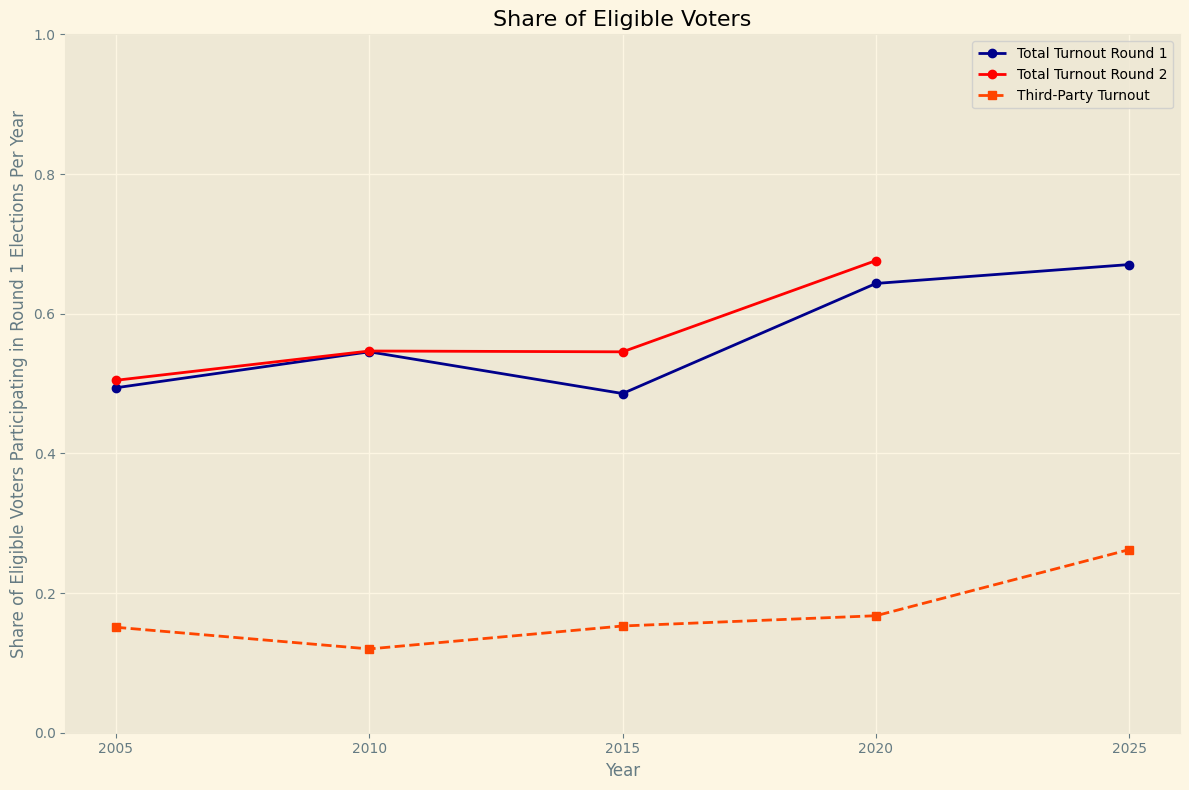

In [48]:
plt.style.use("Solarize_Light2")

dfs = [round_1_2005, round_1_2010, round_1_2015, round_1_2020, round_1_2025]
dfs_2 = [round_2_2005, round_2_2010, round_2_2015, round_2_2020]
years = ["2005", "2010", "2015", "2020", "2025"]

weighted_turnouts_1 = [
    (df["Turnout"] * df["Eligible_Voters"]).sum() / df["Eligible_Voters"].sum()
    for df in dfs
]

weighted_turnouts_2 = [
    (df["Turnout"] * df["Eligible_Voters"]).sum() / df["Eligible_Voters"].sum()
    for df in dfs_2
]

third_party_turnouts = [
    (df["Third_party_turnout"] * df["Eligible_Voters"]).sum() / df["Eligible_Voters"].sum()
    for df in dfs
]

plt.figure(figsize=(12, 8))
plt.plot(years, weighted_turnouts_1, marker='o', linestyle='-', color='darkblue', label="Total Turnout Round 1")
plt.plot(years[:-1], weighted_turnouts_2, marker='o', linestyle='-', color='red', label="Total Turnout Round 2")
plt.plot(years, third_party_turnouts, marker='s', linestyle='--', color='orangered', label="Third-Party Turnout")
plt.title("Share of Eligible Voters")
plt.xlabel("Year")
plt.ylabel("Share of Eligible Voters Participating in Round 1 Elections Per Year")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The methodology utilizes the equation below in the OLS regression. The model predicts the change in voter turnout between rounds for a given candidate in a given county as a function of their first round result and the total voting share captured by third parties. For the 2025 election, we provide an estimated range regarding the values of the three parameters, $\beta_0$, $\beta_1$, and $\beta_2$, and execute the regression model based on these estimates. The $\beta_0$ parameter represents a constant shift in vote share that’s independent of past performance or turnout dynamics. The $\beta_1$ parameter captures the effect of past vote share, and generally implies momentum and mobilization within a candidates own base. The $\beta_2$ parameter represents success in capturing third party voters.

$$
\Delta V_{i,k} = \beta_0 + \beta_1 V_{i,k} + \beta_2 \left( T - \sum_j V_{j,k} \right)
$$

- $V_{i,k}$ – percentage result of candidate $i$ in county $k$  
- $T$ – Total turnout in percentage terms for county $k$




Here we set up data sets for each election for each candidate in order to be able to run the regression.

In [49]:
kaczynski_2005 = pd.merge(round_1_2005.filter(["County_Code", "Powiat", "Kaczyński", "Third_party_turnout"]), round_2_2005.filter(["County_Code", "Kaczyński"]), on="County_Code", how="left", suffixes=["_1", "_2"])
kaczynski_2005["Change"] = kaczynski_2005["Kaczyński_2"]-kaczynski_2005["Kaczyński_1"]

kaczynski_2010 = pd.merge(round_1_2010.filter(["County_Code", "Powiat", "Kaczyński", "Third_party_turnout"]), round_2_2010.filter(["County_Code", "Kaczyński"]), on="County_Code", how="left", suffixes=["_1", "_2"])
kaczynski_2010["Change"] = kaczynski_2010["Kaczyński_2"]-kaczynski_2010["Kaczyński_1"]

duda_2015 = pd.merge(round_1_2015.filter(["County_Code", "Powiat", "Duda", "Third_party_turnout"]), round_2_2015.filter(["County_Code", "Duda"]), on="County_Code", how="left", suffixes=["_1", "_2"])
duda_2015["Change"] = duda_2015["Duda_2"]-duda_2015["Duda_1"]

duda_2020 = pd.merge(round_1_2020.filter(["County_Code", "Powiat", "Duda", "Third_party_turnout"]), round_2_2020.filter(["County_Code", "Duda"]), on="County_Code", how="left", suffixes=["_1", "_2"])
duda_2020["Change"] = duda_2020["Duda_2"]-duda_2020["Duda_1"]

tusk_2005 = pd.merge(round_1_2005.filter(["County_Code", "Powiat", "Tusk", "Third_party_turnout"]), round_2_2005.filter(["County_Code", "Tusk"]), on="County_Code", how="left", suffixes=["_1", "_2"])
tusk_2005["Change"] = tusk_2005["Tusk_2"]-tusk_2005["Tusk_1"]

komorowski_2010 = pd.merge(round_1_2010.filter(["County_Code", "Powiat", "Komorowski", "Third_party_turnout"]), round_2_2010.filter(["County_Code", "Komorowski"]), on="County_Code", how="left", suffixes=["_1", "_2"])
komorowski_2010["Change"] = komorowski_2010["Komorowski_2"]-komorowski_2010["Komorowski_1"]

komorowski_2015 = pd.merge(round_1_2015.filter(["County_Code", "Powiat", "Komorowski", "Third_party_turnout"]), round_2_2015.filter(["County_Code", "Komorowski"]), on="County_Code", how="left", suffixes=["_1", "_2"])
komorowski_2015["Change"] = komorowski_2015["Komorowski_2"]-komorowski_2015["Komorowski_1"]

trzaskowski_2020 = pd.merge(round_1_2020.filter(["County_Code", "Powiat", "Trzaskowski", "Third_party_turnout"]), round_2_2020.filter(["County_Code", "Trzaskowski"]), on="County_Code", how="left", suffixes=["_1", "_2"])
trzaskowski_2020["Change"] = trzaskowski_2020["Trzaskowski_2"]-trzaskowski_2020["Trzaskowski_1"]

In [50]:
kaczynski_2005["Kaczyński_2"] = kaczynski_2005["Kaczyński_2"].astype(float)
kaczynski_2005["Change"] = kaczynski_2005["Change"].astype(float)
tusk_2005["Tusk_2"] = tusk_2005["Tusk_2"].astype(float)
tusk_2005["Change"] = tusk_2005["Change"].astype(float)

This function allows for the creation of quick visuals representing how county turnouts changed for a candidate in a given election.

In [51]:
def create_change_reg_plot(df, candidate, year):    
    
    plt.figure(figsize=(10, 6))
    sns.regplot(x=f"{candidate}_1", y="Change", data=df)
    
    slope, intercept, r_value, p_value, std_err = linregress(
        df[f"{candidate}_1"], df["Change"]
    )
    
    equation_text = f"y = {intercept:.3f} + {slope:.3f}x\n$R^2$ = {r_value**2:.2f}"
    
    plt.annotate(equation_text, xy=(0.05, 0.95), xycoords='axes fraction',
                 fontsize=12, ha='left', va='top',
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))
    
    plt.xlabel(f"{candidate} Round 1 Turnout ({year})")
    plt.ylabel(f"Round 2 Turnout Increase ({candidate})")
    plt.title(f"{candidate}: Round 1 Turnout vs Round 2 Turnout Increase ({year}) by County")
    
    plt.show()

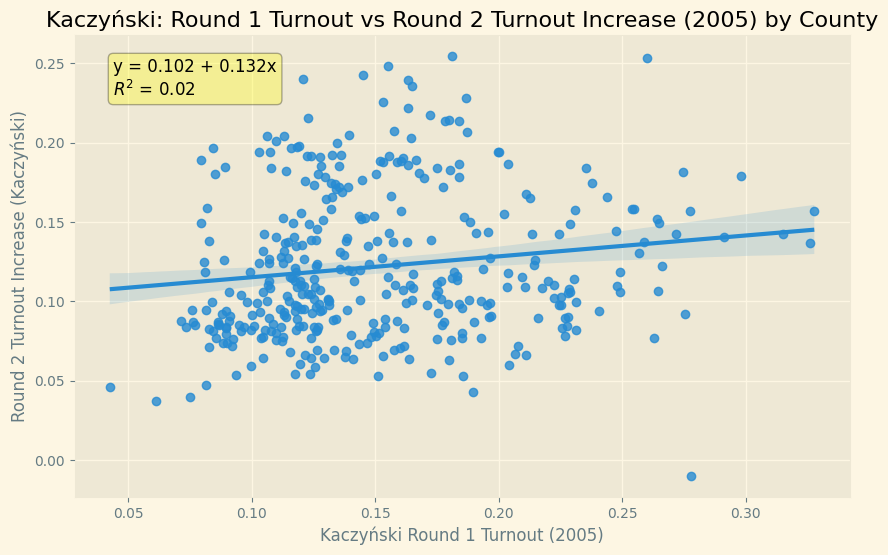

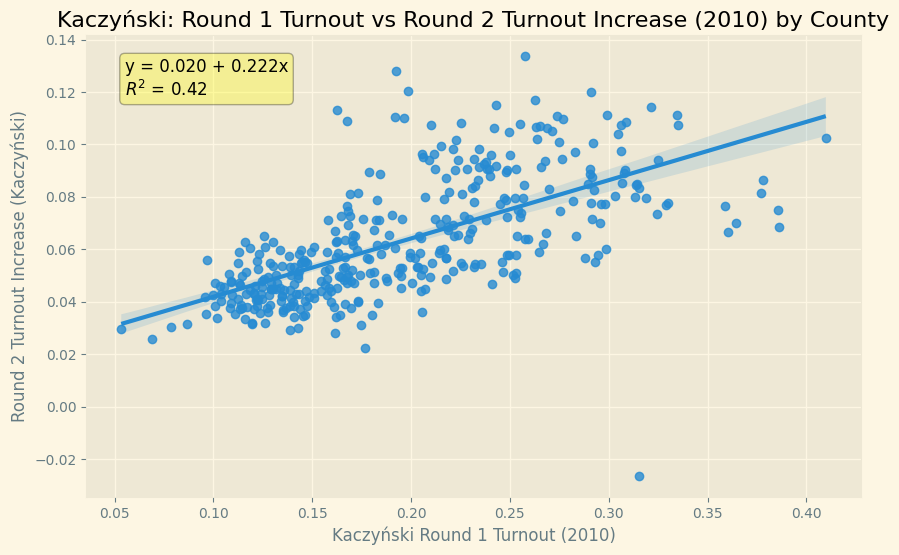

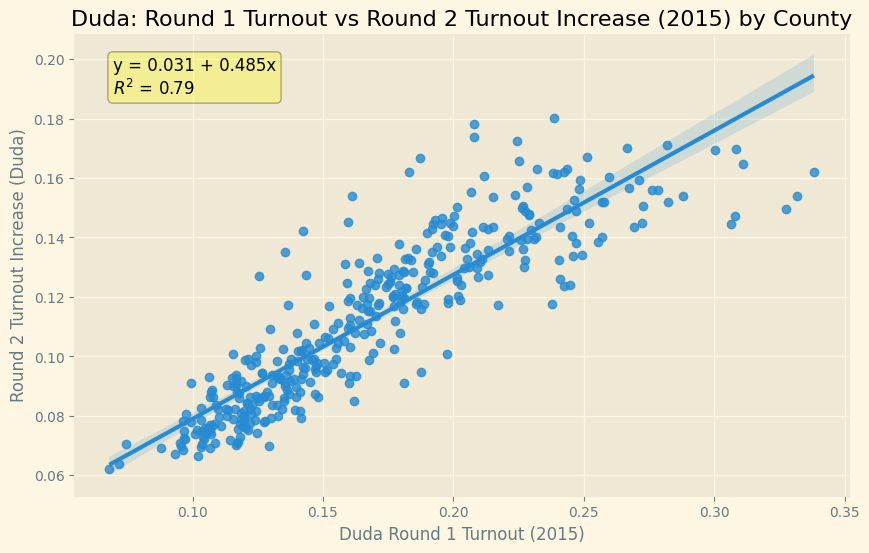

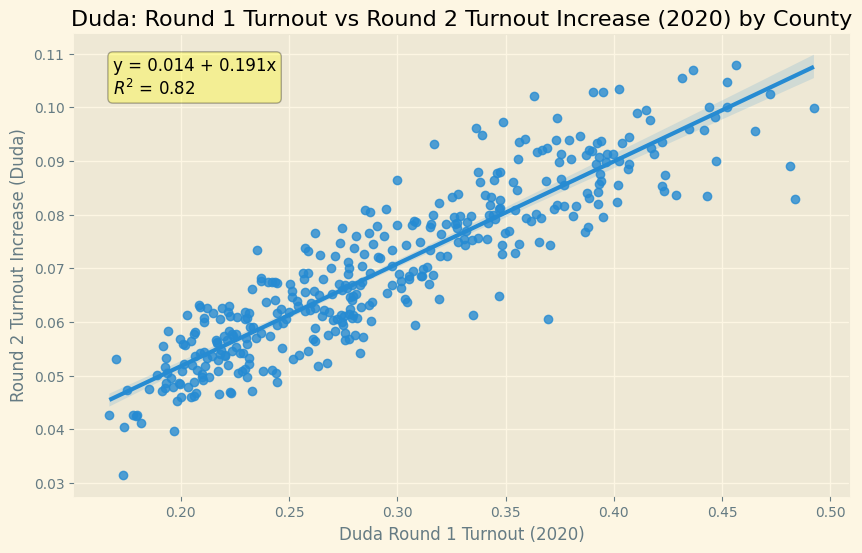

In [52]:
create_change_reg_plot(kaczynski_2005, "Kaczyński", year=2005)
create_change_reg_plot(kaczynski_2010, "Kaczyński", year=2010)
create_change_reg_plot(duda_2015, "Duda", year=2015)
create_change_reg_plot(duda_2020, "Duda", year=2020)

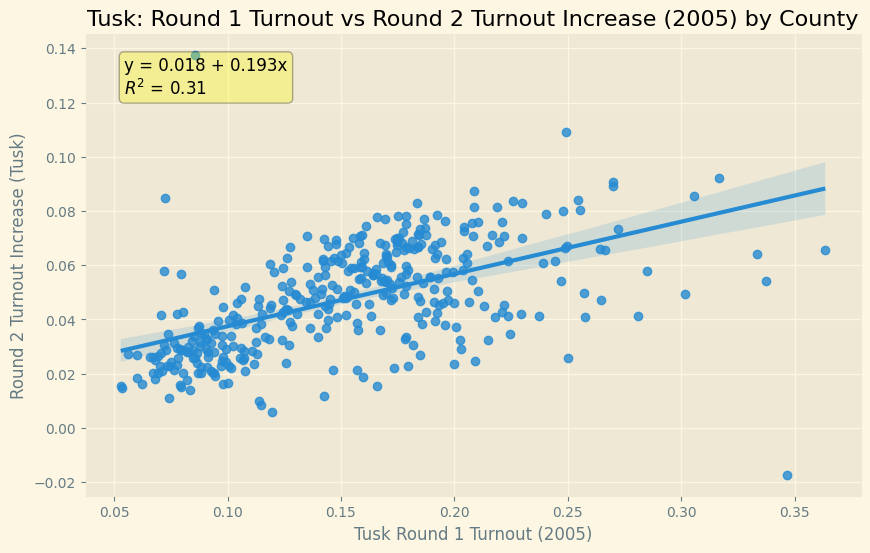

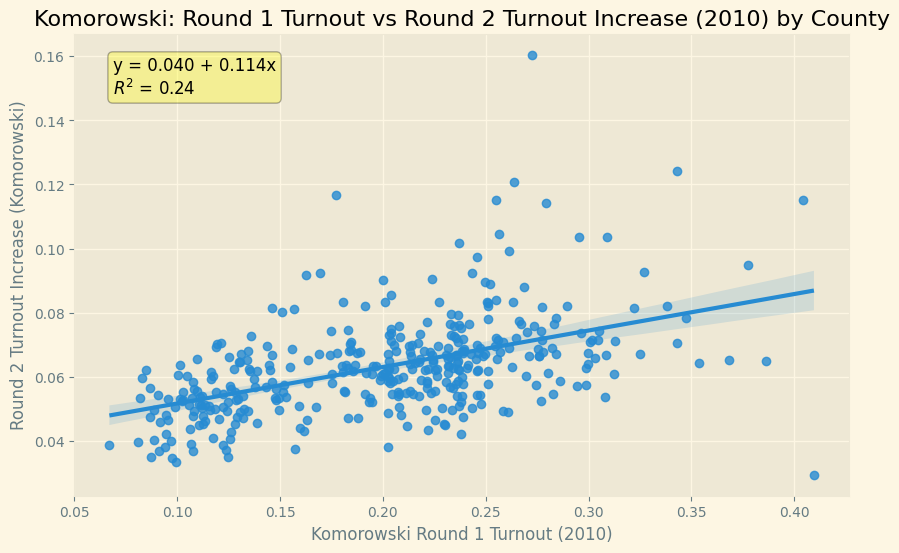

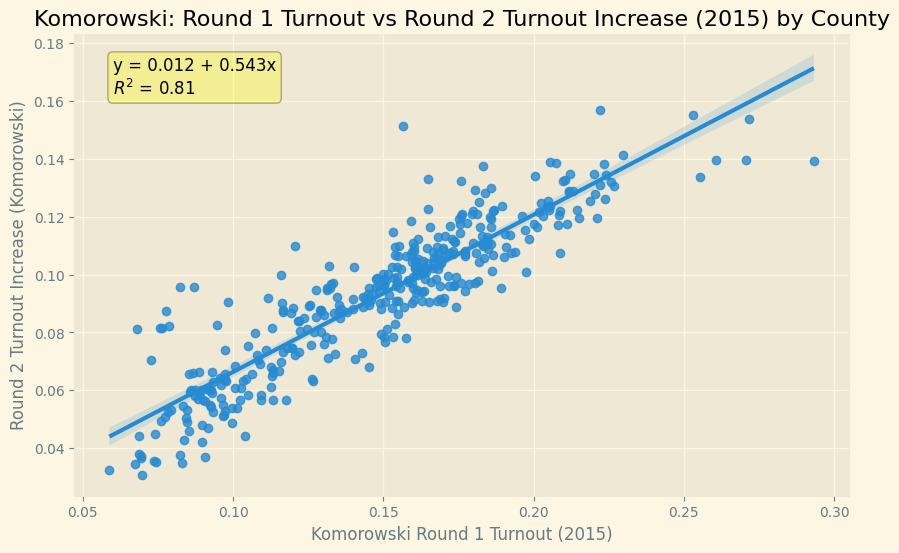

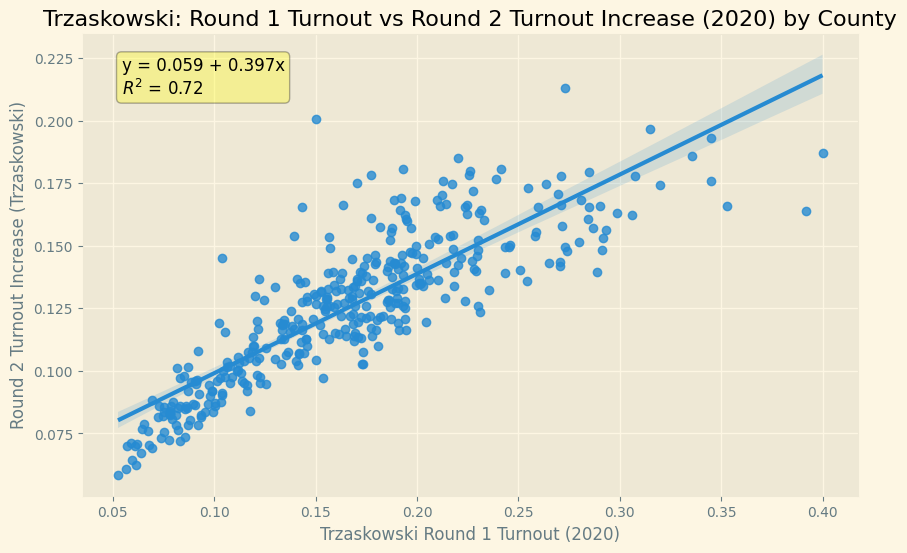

In [53]:
create_change_reg_plot(tusk_2005, "Tusk", year=2005)
create_change_reg_plot(komorowski_2010, "Komorowski", year=2010)
create_change_reg_plot(komorowski_2015, "Komorowski", year=2015)
create_change_reg_plot(trzaskowski_2020, "Trzaskowski", year=2020)

We run the regression for all PiS and PO candidates and collect the coefficients alongside their standard errors. I also added their first round results and how that compared to their opponent.

In [54]:
pis_coefficients = []

for df, candidate, year in [
    (kaczynski_2005, "Kaczyński", 2005),
    (kaczynski_2010, "Kaczyński", 2010),
    (duda_2015, "Duda", 2015),
    (duda_2020, "Duda", 2020)
]:
    X = df[[f"{candidate}_1", "Third_party_turnout"]]
    X = sm.add_constant(X)
    y = df["Change"]
    model = sm.OLS(y, X).fit()
    pis_coefficients.append({
        "candidate": candidate,
        "year": year,
        "b0": model.params["const"],
        "b0SE": model.bse["const"],
        "b1": model.params[f"{candidate}_1"],
        "b1SE": model.bse[f"{candidate}_1"],
        "b2": model.params["Third_party_turnout"],
        "b2SE": model.bse["Third_party_turnout"]
    })

pis_coefficients = pd.DataFrame(pis_coefficients)

pis_coefficients.loc[4] = ["Nawrocki", 2025, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

pis_coefficients["First_Round_Result"] = [.331, .365, .3476, .435, .295]
pis_coefficients["First_Round_Lead"] = [.331-.3633, .365-.415, .3476-.3377, .435-.3046, .295-.3136]
pis_coefficients

,candidate,year,b0,b0SE,b1,b1SE,b2,b2SE,First_Round_Result,First_Round_Lead
0,Kaczyński,2005,-0.116806,0.006845,0.481533,0.023257,1.012756,0.027520,0.3310,-0.0323
1,Kaczyński,2010,-0.038309,0.007254,0.252832,0.012930,0.435139,0.050881,0.3650,-0.0500
2,Duda,2015,0.001282,0.003640,0.473884,0.011705,0.216462,0.022279,0.3476,0.0099
3,Duda,2020,0.015208,0.003911,0.189451,0.005626,-0.007620,0.017271,0.4350,0.1304
4,Nawrocki,2025,NaN,NaN,NaN,NaN,NaN,NaN,0.2950,-0.0186


In [55]:
po_coefficients = []

for df, candidate, year in [
    (tusk_2005, "Tusk", 2005),
    (komorowski_2010, "Komorowski", 2010),
    (komorowski_2015, "Komorowski", 2015),
    (trzaskowski_2020, "Trzaskowski", 2020)
]:
    X = df[[f"{candidate}_1", "Third_party_turnout"]]
    X = sm.add_constant(X)
    y = df["Change"]
    model = sm.OLS(y, X).fit()
    po_coefficients.append({
        "candidate": candidate,
        "year": year,
        "b0": model.params["const"],
        "b0SE": model.bse["const"],
        "b1": model.params[f"{candidate}_1"],
        "b1SE": model.bse[f"{candidate}_1"],
        "b2": model.params["Third_party_turnout"],
        "b2SE": model.bse["Third_party_turnout"]
    })

po_coefficients = pd.DataFrame(po_coefficients)

po_coefficients.loc[4] = ["Trzaskowski", 2025, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

po_coefficients["First_Round_Result"] = [.3633, .415, .3377, .3046, .3136]
po_coefficients["First_Round_Lead"] = [.3633-.331, .415-.365, .3377-.3476,.3046 -.435,.3136-.295]
po_coefficients



,candidate,year,b0,b0SE,b1,b1SE,b2,b2SE,First_Round_Result,First_Round_Lead
0,Tusk,2005,-0.036701,0.006191,0.310799,0.018226,0.225188,0.023803,0.3633,0.0323
1,Komorowski,2010,0.010923,0.004823,0.104623,0.009854,0.261003,0.038766,0.4150,0.0500
2,Komorowski,2015,0.002850,0.003367,0.535901,0.013384,0.071652,0.020934,0.3377,-0.0099
3,Trzaskowski,2020,-0.002114,0.004770,0.252104,0.014607,0.542863,0.038879,0.3046,-0.1304
4,Trzaskowski,2025,NaN,NaN,NaN,NaN,NaN,NaN,0.3136,0.0186


### Determining Possible Coefficient Ranges for 2025 Election

Next, we must determine possible ranges for these coefficients for both Trzaskowski and Nawrocki, utilizing general political context and previous results. It is immediately evident that **2020** provides generally strange results compared to other elections. 

- The $\beta_1$ parameter **generally falls** as a candidate's first round result increases when examining pre-2020 results. 
- The **2015 election** provides the best comparison to 2025 due to its close first round result. 

The first round of 2025 provides slightly lower results compared to 2015 for both parties, indicating that the **$\beta_1$** parameter range could be **larger** than the 2015 values as there is more room for a candidate to mobilize their own base. 

For the **PO** candidate, I set a range of **0.45 to 0.65**, and for **PiS**, I set this range to **0.4-0.6**. Based on historical trends, it is fair to assume that these coefficients could be higher than 2015. 

Typically, the **leading candidate** exhibits a smaller $\beta_1$ parameter, but I believe that both PO's voter base is generally more stable due to its concentration in urban areas, and Trzaskowski underperforming his expectations in the first round provides a slight edge in terms of mobilization. 

For the **$\beta_2$** parameter:
- I gave **PO** a range of **0.05 to 0.3**.
- **PiS** a range of **0.15 to 0.4**.

PiS historically outperforms PO with respect to this parameter, but the third party in the **2025 election** is difficult to predict, comprising a wide range of voters. Generally, the main third party candidate is viewed as slightly more **right-wing**, which is why PiS has a slight edge in this parameter. However, **Trzaskowski** had a strong 3rd party showing in 2020.

The **$\beta_0$** coefficient has historically slightly favored the PO candidate, and with a generally high first round turnout in 2025, I provide a conservative estimate of the two ranges:
- **PO**: **-.02 to 0**
- **PiS**: **-.05 to -.01**

With these ranges, we simulate **1,000,000 elections**, where we divide each parameter range into 10 equally spaced values and simulate every possible combination.

In [56]:
trzaskowski_2025 = round_1_2025[["County_Code", "Powiat", "Eligible_Voters", "Trzaskowski", "Third_party_turnout"]]
nawrocki_2025 = round_1_2025[["County_Code", "Powiat", "Eligible_Voters", "Nawrocki", "Third_party_turnout"]]


In [57]:
V_po = trzaskowski_2025["Trzaskowski"].values
third_po = trzaskowski_2025["Third_party_turnout"].values
eligible_voters = trzaskowski_2025["Eligible_Voters"].values

V_pis = nawrocki_2025["Nawrocki"].values
third_pis = nawrocki_2025["Third_party_turnout"].values

b0_po_vals = np.linspace(-0.02, 0.0, 10)
b1_po_vals = np.linspace(0.45, 0.65, 10)
b2_po_vals = np.linspace(0.05, 0.3, 10)

b0_pis_vals = np.linspace(-0.05, -0.01, 10)
b1_pis_vals = np.linspace(0.4, 0.6, 10)
b2_pis_vals = np.linspace(0.15, 0.4, 10)

sim_po_all = []
sim_pis_all = []

for (b0_po, b1_po, b2_po), (b0_pis, b1_pis, b2_pis) in product(
    product(b0_po_vals, b1_po_vals, b2_po_vals),
    product(b0_pis_vals, b1_pis_vals, b2_pis_vals)
):
    sim_po = b0_po + b1_po * V_po + b2_po * third_po
    sim_pis = b0_pis + b1_pis * V_pis + b2_pis * third_pis

    po_weighted_votes = (sim_po * eligible_voters).sum()
    pis_weighted_votes = (sim_pis * eligible_voters).sum()

    sim_po_all.append(po_weighted_votes)
    sim_pis_all.append(pis_weighted_votes)

sim_po_all = np.array(sim_po_all)
sim_pis_all = np.array(sim_pis_all)

relative_po_share = sim_po_all / (sim_po_all + sim_pis_all)
relative_pis_share = sim_pis_all / (sim_po_all + sim_pis_all)


The mean of Trzaskowski's vote share distribution is 51.8%, and subsequently Nawrocki's figure is 48.2%, creating an average margin of victory of 3.6%. The standard deviation is 5.9%. Of the 1,000,000 simulations, 603,000 resulted in Trzaskowski's victory, a percentage of 60.3%.

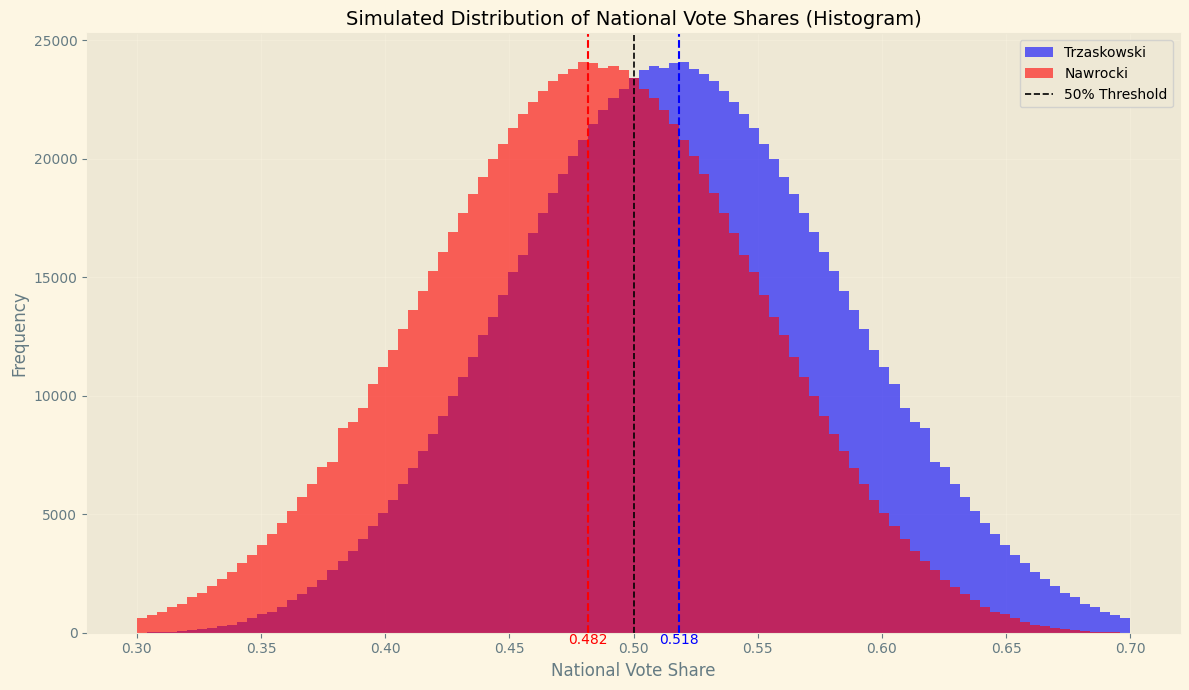

In [58]:
mean_po = relative_po_share.mean()
mean_pis = relative_pis_share.mean()

plt.figure(figsize=(12, 7))

bins = np.linspace(0.3, 0.7, 100)  # Adjust range and bin count as needed
plt.hist(relative_po_share, bins=bins, alpha=0.6, color='blue', label='Trzaskowski')
plt.hist(relative_pis_share, bins=bins, alpha=0.6, color='red', label='Nawrocki')

# Mean lines
plt.axvline(mean_po, color='blue', linestyle='--', linewidth=1.5)
plt.axvline(mean_pis, color='red', linestyle='--', linewidth=1.5)

plt.axvline(0.5, color='black', linestyle='--', linewidth=1.2, label='50% Threshold')

plt.text(mean_po, -0.5, f'{mean_po:.3f}', color='blue', ha='center', va='top', fontsize=10)
plt.text(mean_pis, -0.5, f'{mean_pis:.3f}', color='red', ha='center', va='top', fontsize=10)

plt.xlabel("National Vote Share", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Simulated Distribution of National Vote Shares (Histogram)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

PiS win probability: 0.397
PO win probability:  0.603


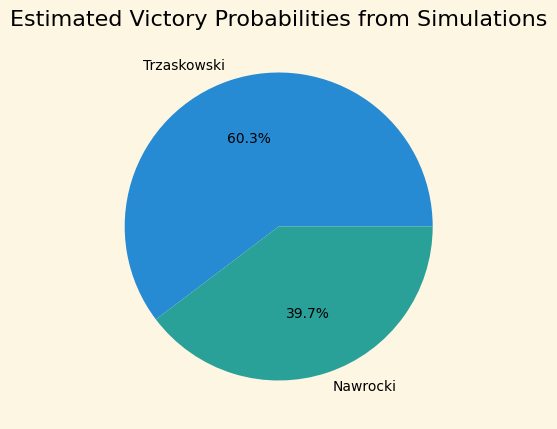

In [59]:
pis_wins = (relative_pis_share > relative_po_share).sum()
po_wins = (relative_po_share > relative_pis_share).sum()
ties = len(relative_po_share) - pis_wins - po_wins

pis_win_prob = pis_wins / len(relative_po_share)
po_win_prob = po_wins / len(relative_po_share)
tie_prob = ties / len(relative_po_share)

print(f"PiS win probability: {pis_win_prob:.3f}")
print(f"PO win probability:  {po_win_prob:.3f}")

plt.figure(figsize=(12,5))

plt.pie([po_win_prob, pis_win_prob], labels=["Trzaskowski", "Nawrocki"], autopct='%1.1f%%')
plt.title("Estimated Victory Probabilities from Simulations")
plt.show()


3.6825623937152137


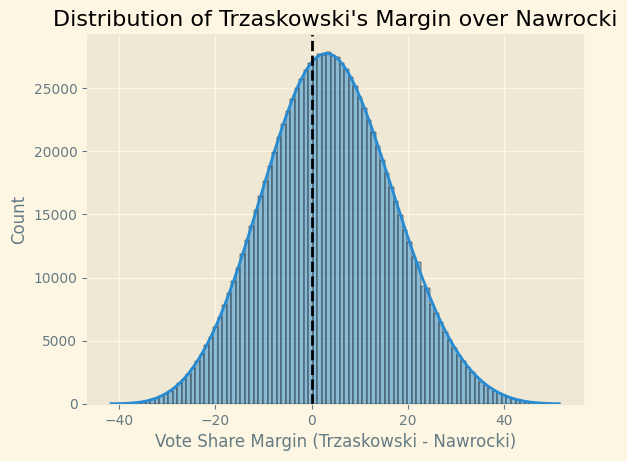

In [60]:
margin = (relative_po_share - relative_pis_share)*100
print(margin.mean())
sns.histplot(margin, kde=True, bins=100)
plt.axvline(0, color='black', linestyle='--')
plt.title("Distribution of Trzaskowski's Margin over Nawrocki")
plt.xlabel("Vote Share Margin (Trzaskowski - Nawrocki)")
plt.show()


 # Conclusion

The methodology is obviously subjective, using personally defined ranges based on judgements driven by previous results and interpretations of the current Polish political context. The results are only as good as the input parameter ranges, and if these ranges are innacurate, we cannot expect a realistic forecast of the outcome. Everything written and executed in this notebook is as of May 26th, 9:30 AM, leaving 5 days until the second round of the election which takes place on the 1st of June. I again want to give credit to [Cezary Klimczuk](https://towardsdatascience.com/president-duda-heading-for-a-firm-re-election-according-to-262-144-simulations-3f5f6ceddb04/), whose work was the inspiration behind my attempt to predict the outcome of the 2025 Polish Presidential Election.